# Building makemore: building a WaveNet

https://www.youtube.com/watch?v=t3YJ5hKiMQ0

Current architecture: multilayer perceptron with 3 previous characters, predicting next with a single hidden layer (tanh)

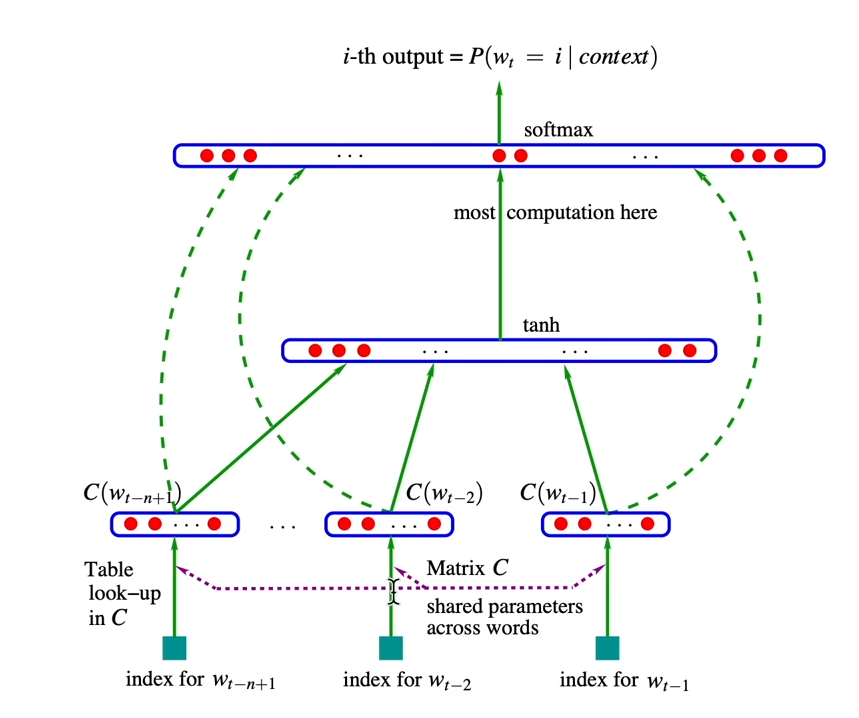

More complex architecture moves toward something that looks like a WaveNet.

2016 publication - was used for predicting audio sequences, but architecture is the same as what we're doing with a recurrent neural network, with a tree-like structure.

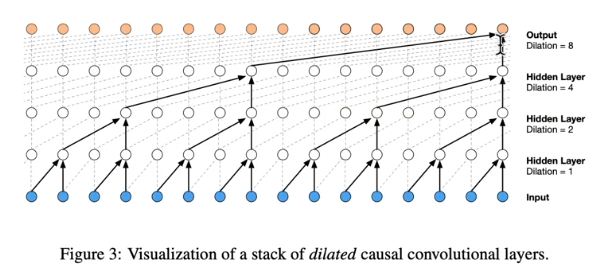

# Starter code

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('./makemore/names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [5]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [6]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


Copy of part 3 final code: nice modular blocks that can be stacked into neural network layers. API is similar to the ones in PyTorch.

In [7]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:
  # Matrix multiplication layer
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  # Normalizes what's passed into the layer
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  # Just Tanh
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

In [8]:
# This takes the place of the generator g used in previous lectures
torch.manual_seed(42); # seed rng for reproducibility

In [9]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

C = torch.randn((vocab_size, n_embd))
layers = [
  Linear(n_embd * block_size, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
]

# parameter init
with torch.no_grad():
  layers[-1].weight *= 0.1 # last layer make less confident

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

22097


In [10]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), )
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.2847
  10000/ 200000: 2.0647
  20000/ 200000: 1.9722
  30000/ 200000: 2.0948
  40000/ 200000: 1.9738
  50000/ 200000: 2.1287
  60000/ 200000: 2.3574
  70000/ 200000: 1.9131
  80000/ 200000: 2.0735
  90000/ 200000: 2.0968
 100000/ 200000: 1.4963
 110000/ 200000: 2.1294
 120000/ 200000: 2.2324
 130000/ 200000: 2.2071
 140000/ 200000: 2.2326
 150000/ 200000: 1.8908
 160000/ 200000: 1.6867
 170000/ 200000: 2.0968
 180000/ 200000: 1.7824
 190000/ 200000: 1.9151


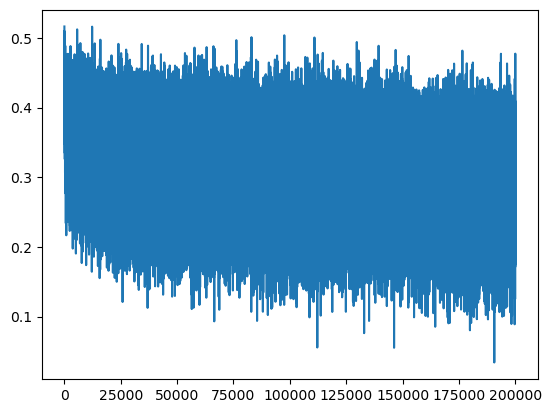

In [11]:
plt.plot(lossi)

This is very "bouncy" because batch size 32 is probably too small. Could use larger batch size to fix this.

In [13]:
# put layers into eval mode (needed for batchnorm especially)
for layer in layers:
  layer.training = False

In [14]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9163438081741333
val 2.034248113632202


This is pretty good. Sampling from the model should yield decent results:

In [15]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1, block_size, n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
         x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

yeverii.
kya.
kylek.
tisire.
porbyn.
abib.
merighlynn.
loriel.
jiildy.
davryah.
brone.
thorder.
nyleah.
miromell.
oluwase.
josusas.
ramia.
herlio.
delina.
maclai.


# Optimizing

## lossi plot

First thing as mentioned above is to get a better lossi plot - the original is much too bouncy.

Recall: in pytorch you can recast a 1D array into a matrix or tensor, etc. Can use this to get a moving average of lossi, rather than the bouncy plot.

In [17]:
print(torch.arange(10))
print(torch.arange(10).view(2, 5))

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]])


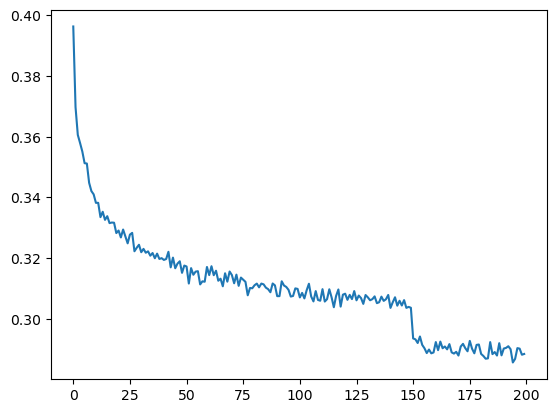

In [20]:
# Stretch into a row of 1000 consecutive elements and do row means
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

This is basically a smoothed average; see around 150k iterations it settled into about the final state.

## Simplifying the forward pass

Current forwad pass takes a lot of lines of code; why not just add embedding definition and the viewing operation to our layers list?

Embedding table lookup is done with indexing, and view option rearranges the character embeddings and stretches them into a row. Can easily be made into simple functions.

New defs (same signature as Pytorch as before):

In [21]:
# -----------------------------------------------------------------------------------------------
class Embedding:
  # Indexing operation for the forward pass
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
    
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]
  
# -----------------------------------------------------------------------------------------------
class Flatten:
  # Flattening operation
  
  def __call__(self, x):
    self.out = x.view(x.shape[0], -1)
    return self.out
  
  def parameters(self):
    return []

In [22]:
torch.manual_seed(42); # Reset seed

In [25]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

# C = torch.randn((vocab_size, n_embd))
# Don't need C anymore

layers = [
  Embedding(vocab_size, n_embd),
  Flatten(),
  Linear(n_embd * block_size, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
]

# parameter init
with torch.no_grad():
  layers[-1].weight *= 0.1 # last layer make less confident

parameters = [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

22097


In [26]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), )
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  # These are inside layers now
  # emb = C[Xb] # embed the characters into vectors
  # x = emb.view(emb.shape[0], -1) # concatenate the vectors
  x = Xb
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  break

      0/ 200000: 3.2825


First iteration runs: great!

## Sequentials

Concept of containers, a way of organizing layers into lists, dicts, etc. We want to create one that passes a list of containers.

In [43]:
# -----------------------------------------------------------------------------------------------
class Sequential:
  # Pass in a list of layers
  # In forward pass, pass in layers and return result
  # Parameters iterate through the child modules
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

In [42]:
torch.manual_seed(42); # Reset seed

In [44]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

# C = torch.randn((vocab_size, n_embd))
# Don't need C anymore

# Use sequential instead of layers
model = Sequential([
  Embedding(vocab_size, n_embd),
  Flatten(),
  Linear(n_embd * block_size, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  layers[-1].weight *= 0.1 # last layer make less confident

# Use sequential defs
#parameters = [p for layer in layers for p in layer.parameters()]
parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

22097


In [45]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), )
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  # Now just call the model on the input data
  #x = Xb
  #for layer in layers:
  #  x = layer(x)
  logits = model(Xb)
  #loss = F.cross_entropy(x, Yb) # loss function
  loss = F.cross_entropy(logits, Yb)

  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  break

      0/ 200000: 3.3804


Again, first iterations run fine.

Also need to update the loss evaluation and sampling functions with our new model object.

In [46]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

Very important to run the above or batchnorm layer will cause issues (variance of single number is NaN) which pollutes further processing. He explains this error in the video around 16:00.

In [47]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  # Replace all this with our model
  #emb = C[x] # (N, block_size, n_embd)
  #x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  #for layer in layers:
  #  x = layer(x)
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 3.702629804611206
val 3.7091329097747803


In [48]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      #emb = C[torch.tensor([context])] # (1, block_size, n_embd)
      #x = emb.view(emb.shape[0], -1) # concatenate the vectors
      #for layer in layers:
      #   x = layer(x)
      #logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

sgrdmeeoaemxhsjwvabkode.
vrrwsvouggijnztmcmqztzkxmqmxw.
krlpj.
plvuwssdayfdwfjqucxrxeytqatbogoxxtauickneqgnfinjaqfqfqgmhcyxqkemomkgoooedznigdngylmtqrfnettincelynoxehw.
.
lpsphzzninoeqnfgbeaehzbxqwslljmiryzdauejvfegvgojxscndeeadseehqkurojqxphamoasaajgxrxfpcvqcyahucmdaycllotmsimfmfaawusaxy.
glwrprekt.
tpppnslsaibemmqobxdbolzamietamq.
vvcgcwwbqoodbzaeierqimpzpvdbgfvcy.
whnspocegffzpeqqymxinwqtscasqgrjukahjirztugjvjhqlucptuusnazeqlanrv.
ggpmhswdgzeityyccumhjcalduzefjnsamuzm.
fillnpdedh.
wkwvffpohzmzuywjhxjkjjtzwiaeysnhmzahqwhqkmnbeaxosmfuegfiweauxnojhrmovcgxehhkktgfvxiudyfuvyrjnqlhdafsqvamacl.
kcmjggklz.
crrgpkvzyaqhshoxhekerapjkidxedoubp.
jvzbgzpzexjuueafiajtuvueriznbyozc.
zdwpzsuhdy.
vrpsppfnhuf.
mzwcdssohqyiatuthyzrbgmgnd.
mrrpjjesywqtsloxkmigejmgcd.


# Updated model

Running the new model:

In [49]:
torch.manual_seed(42); # Reset seed

In [50]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

# C = torch.randn((vocab_size, n_embd))
# Don't need C anymore

# Use sequential instead of layers
model = Sequential([
  Embedding(vocab_size, n_embd),
  Flatten(),
  Linear(n_embd * block_size, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  layers[-1].weight *= 0.1 # last layer make less confident

# Use sequential defs
#parameters = [p for layer in layers for p in layer.parameters()]
parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

22097


In [51]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), )
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  # Now just call the model on the input data
  #x = Xb
  #for layer in layers:
  #  x = layer(x)
  logits = model(Xb)
  #loss = F.cross_entropy(x, Yb) # loss function
  loss = F.cross_entropy(logits, Yb)

  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3804
  10000/ 200000: 2.0859
  20000/ 200000: 1.9975
  30000/ 200000: 2.0456
  40000/ 200000: 2.0530
  50000/ 200000: 2.0230
  60000/ 200000: 2.3334
  70000/ 200000: 1.9597
  80000/ 200000: 2.2143
  90000/ 200000: 1.9593
 100000/ 200000: 1.5477
 110000/ 200000: 2.2521
 120000/ 200000: 2.3547
 130000/ 200000: 2.2826
 140000/ 200000: 2.1726
 150000/ 200000: 1.9499
 160000/ 200000: 1.5848
 170000/ 200000: 2.2562
 180000/ 200000: 1.8180
 190000/ 200000: 2.0273


In [52]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

In [53]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  # Replace all this with our model
  #emb = C[x] # (N, block_size, n_embd)
  #x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  #for layer in layers:
  #  x = layer(x)
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9185395240783691
val 2.0278825759887695


Losses are similar in training and validation set, so we don't have to worry about overfitting. Can continue making model more complex.

In [54]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      #emb = C[torch.tensor([context])] # (1, block_size, n_embd)
      #x = emb.view(emb.shape[0], -1) # concatenate the vectors
      #for layer in layers:
      #   x = layer(x)
      #logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

yevorie.
kya.
kylek.
tiskin.
porbyn.
abigi.
eringtynne.
abigracii.
dakeyo.
yaremi.
aerika.
deveny.
eviongar.
leilob.
jase.
josuhan.
rimias.
elliopa.
livitha.
jaiker.
